Il existe de nombreux *solveurs linéaires*, c'est-à-dire des logiciels capables de résoudre des programmes linéaires (continus ou en nombres entiers). Certains sont gratuits (comme GLPK (*Gnu Linear Programming Kit*), ou le solveur intégré à LibreOffice Calc), d'autres sont payants (comme IBM Cplex, Gurobi, XPress...) et sont capables de résoudre des problèmes comportant plusieurs dizaines de milliers de variables ou de contraintes.

Il existe également des bibliothèques pour tous les langages de programmation. Dans ce TP, vous utiliserez dans un premier temps la bibliothèque **SciPy** (la principale bibliothèque de calcul scientifique en Python). Vous découvrirez ensuite la bibliothèque **PuLP** qui permet de *modéliser* un programme linéaire, et qu'on peut ensuite connecter à de nombreux solveurs pour résoudre le dit programme ; ici, vous utiliserez **GLPK**.

# Utilisation de SciPy pour la programmation linéaire

Pour définir et résoudre des programmes linéaires avec SciPy, la première chose à faire est d'importer le module `scipy.optimize.linprog` :

In [2]:
from scipy.optimize import linprog

Nous allons voir comment résoudre le programme linéaire suivant :
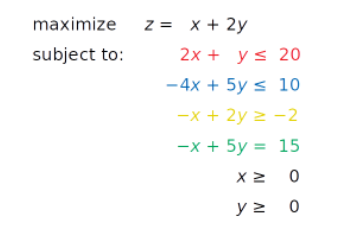

#### Exercice : commencez par représenter graphiquement ce problème à l'aide de l'outil en ligne Geogebra
Identifiez le polygone des solutions réalisables puis déterminez les coordonnées de la solution optimale

💡 Pour chaque contrainte, cochez la case `Inverser le remplissage`, dans l'onglet `Style` de ses propriétés
___

Le problème avec `linprog`, c'est qu'il n'accepte que les programmes linéaires ayant une forme bien particulière :
* seulement des problèmes de *minimisation*
* seulement des contraintes de type *inférieur à* ($\leq$)

En fait, ce n'est pas un problème, et on peut très facilement transformer n'importe quel programme linéaire en un programme linéaire ayant la forme demandée :
* plutôt que *maximiser* la fonction $z = x + 2y$, on va *minimiser* son *opposée* (c'est-à-dire qu'on va multiplier les deux membres de l'égalité par $-1$) : la fonction objectif devient donc `min -z = -x - 2y`
* de même, pour transformer une contrainte de type *supérieur à* ($\geq$) en contrainte de type $\leq$, il suffit de multiplier chaque membre par $-1$ : par exemple, $-x + 2y \geq -2$ devient $x - 2y \leq 2$.

On obtient ainsi un système équivalent au système original, et qui a les mêmes solutions :
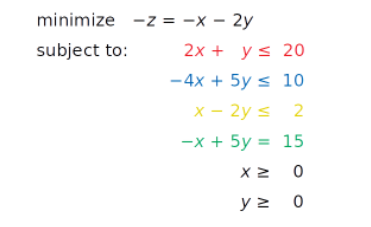

L'étape suivante consiste à saisir toutes les valeurs dans des tableaux Python :

In [3]:
# On commence par la fonction objectif :
obj = [-1, -2]
#      ─┬  ─┬
#       │   └┤ Coefficient de y
#       └────┤ Coefficient de x

# Ensuite, les membres gauches (Left Hand Side en anglais, ou lhs) des inégalités
lhs_ineq = [[ 2,  1],  # contrainte rouge
            [-4,  5],  # contrainte bleue
            [ 1, -2]]  # contrainte jaune

# Puis les membres droits (rhs) des inégalités
rhs_ineq = [20,  # contrainte rouge
            10,  # contrainte bleue
             2]  # contrainte jaune

# On procède de la même manière pour les contraintes de type égalité :
lhs_eq = [[-1, 5]]  # contrainte verte
rhs_eq = [15]       # contrainte verte

⚠️ Chaque liste Python représente une **colonne** ! Pour les coefficients d'une même contrainte, on doit utiliser des listes à deux dimensions !

Il ne faut pas oublier de spécifier le *domaine* des variables, c'est-à-dire les valeurs qu'elles peuvent prendre. Dans notre cas, il s'agit de variables *réelles* (ou *continues*) pouvant prendre toutes les valeurs possibles comprises entre $0$ et $+\infty$ :

In [4]:
# Bornes (bounds en anglais) des variables
bnd = [(0, float("inf")),  # Bornes de x
       (0, float("inf"))]  # Bornes de y

💡 A la place de `float("inf")`, vous pouvez utiliser `math.inf`, `numpy.inf`, ou `scipy.inf`.

Il ne reste plus qu'à passer tous ces éléments à la méthode `linprog` :

In [5]:
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
              method="revised simplex")
opt

C:\Users\ACHRO\AppData\Local\Temp\ipykernel_11168\1019385060.py:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -16.818181818181817
       x: [ 7.727e+00  4.545e+00]
     nit: 3

💡 Le paramètre `method` permet de spécifier l'algorithme à utiliser. Il y a trois choix possibles :
* `simplex` est l'algorithme du simplexe original, qui peut "buter" sur certains problèmes
* `revised_simplex` est une version améliorée du simplexe, dite "en deux phases"
* `interior_points` est un algorithme basé sur une méthode appelée "points intérieurs". C'est l'option par défaut.

Ici, on voit que la résolution du problème s'est terminée correctement (`Optimization terminated successfully`).

* L'optimum de la fonction objectif est donné par `fun` (on voit ici qu'il vaut environ `-16.818`)
* `nit` est le nombre d'itérations effectuées par l'algorithme pour trouver la solution
* `status : 0` signifie que l'optimum a été trouvé
* `x` est un tableau contenant les valeurs des variables permettant d'obtenir la solution trouvée.
* `slack` est le tableau des *écarts* par rapport aux bornes de chaque contrainte : par exemple, l'écart de la première contrainte est `0`, ce qui signifie que la solution optimale conduit à `2x + y = 20`. En revanche, on a un écart de `18.1818` sur la deuxième contrainte : en effet, `-4x + 5y = -8.1818` alors qu'on pouvait monter jusqu'à `10`.

On peut accéder à tous ces éléments séparément :

In [6]:
opt.success

True

In [7]:
opt.x

array([7.72727273, 4.54545455])

Quand on calcule le résultat de la fonction objectif avec ces valeurs, on tombe bien sur l'optimum trouvé :

In [8]:
obj[0] * opt.x[0] + obj[1]*opt.x[1]

-16.818181818181817

#### Exercice : résolvez le programme linéaire du cours à l'aide de `scipy.linprog`

In [12]:
obj = [-350, -220]
lhs_ineq = [[4, 2], [1, 3]]
rhs_ineq = [1600, 1500]
bnd = [(0, float("inf")), (0, float("inf"))] 
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")
opt

C:\Users\ACHRO\AppData\Local\Temp\ipykernel_11168\3189828017.py:5: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -159800.0
       x: [ 1.800e+02  4.400e+02]
     nit: 2

SciPy est très pratique pour résoudre des problèmes de petite taille. Néanmoins, il a plusieurs inconvénients :
* il ne permet pas de faire appel à des solveurs externes, plus puissants
* il ne sait pas travailler avec des variables contraintes à être entières
* il ne fournit aucune classe ou méthode qui facilite l'écriture du modèle (tout passe par des listes ou des matrices), ce qui rend complexe et source d'erreur l'écriture de modèles plus grands
* il ne gère pas directement les problèmes de maximisation
* il ne gère pas les contraintes de type "supérieur ou égal à"

Heureusement, il existe de nombreuses alternatives. L'une d'entre elles est `PuLP`, que vous allez découvrir dans la section suivante.

# PuLP

Comme précisé ci-dessus, `PuLP` dispose d'un ensemble de classes et méthodes qui simplifient grandement l'écriture d'un programme linéaire comparé à `SciPy`.

`PuLP` n'est généralement pas préinstallé dans les distributions ; aussi, si vous ne l'avez pas encore, il faut commencer par l'installer :

In [ ]:
!pip install pulp

Il faut ensuite, comme d'habitude, importer tout ce dont nous aurons besoin :

In [13]:
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable

Pour illustrer l'utilisation de `PuLP`, nous allons reprendre le programme linéaire du début du TP :
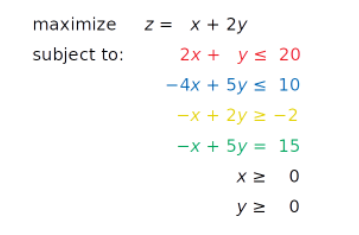

La première étape consiste à initialiser une *instance* de la classe `LpProblem` pour représenter le problème :

In [14]:
# Création du modèle
modele = LpProblem(name="exemple-tp", sense=LpMaximize)

💡 Le paramètre `sense` permet de spécifier si résout un problème de *maximisation* (`LpMaximize`) ou de *minimisation* (`LpMinimize`).

On définit ensuite les variables en tant qu'instances de la classe `LpVariable` :

In [15]:
# Initialisation des variables
x = LpVariable(name="x", lowBound=0)
y = LpVariable(name="y", lowBound=0)

💡 Par défaut, les variables peuvent prendre n'importe quelle valeur comprise entre $-\infty$ et $+\infty$. C'est pourquoi on a besoin ici de spécifier `lowBound=0`.
Il existe également un paramètre `cat` qui permet de définir la *catégorie* d'une variable : continue (`Continuous`, par défaut), entière (`Integer`), binaire (`Binary`)... 

On peut ensuite utiliser ces variables pour créer d'autres objets `PuLP`, qui représentent des expressions linéaires ou des contraintes :

In [16]:
expression = 2 * x + 4 * y
type(expression)

pulp.pulp.LpAffineExpression

In [17]:
constraint = 2 * x + 4 * y >= 8
type(constraint)

pulp.pulp.LpConstraint

Il est ensuite très simple d'ajouter des contraintes au modèle : il suffit d'utiliser l'opérateur `+=` :

In [18]:
# Ajout des contraintes au modèle
modele += (2 * x + y <= 20, "contrainte rouge")
modele += (4 * x - 5 * y >= -10, "contrainte bleue")
modele += (-x + 2 * y >= -2, "contrainte jaune")
modele += (-x + 5 * y == 15, "contrainte verte")

L'ajout de la fonction objectif se fait de manière similaire :

In [19]:
# Ajout de la fonction objectif
obj_func = x + 2 * y
modele += obj_func

💡 Quand on manipule beaucoup de variables, il est plus simple d'utiliser la fonction `lpSum` avec une liste ou un autre objet itérable, plutôt que d'utiliser l'opérateur `+` : par exemple, on aurait pu écrire `modele += lpSum([x, 2 * y])`

Vous pouvez à présent voir la définition complète de votre modèle :

In [20]:
modele

exemple-tp:
MAXIMIZE
1*x + 2*y + 0
SUBJECT TO
contrainte_rouge: 2 x + y <= 20

contrainte_bleue: 4 x - 5 y >= -10

contrainte_jaune: - x + 2 y >= -2

contrainte_verte: - x + 5 y = 15

VARIABLES
x Continuous
y Continuous

Il ne reste plus qu'à demander la résolution du problème !

In [21]:
modele.solve()

1

Cette réponse est plutôt... "concise" ! En fait, la méthode `solve()` renvoie un *statut* (objet `LpStatus`) : il vaut `0` si le modèle n'a pas été résolu, `1` si l'optimum a été trouvé, `-1` si le modèle est irréalisable (le polygone des solutions réalisables est vide), et `-2` si le polygone des solutions réalisables n'est pas borné (ce qui arrive parfois)).

On peut heureusement accéder aux différents éléments du résultat à l'aide des méthodes adéquates :

In [22]:
modele.objective.value()

16.8181817

In [23]:
for var in modele.variables():
    print(f"{var.name}: {var.value()}")

x: 7.7272727
y: 4.5454545


Comme avec SciPy, on peut obtenir la valeur des *écarts* des contraintes :

In [24]:
for nom, ecart in modele.constraints.items():
...     print(f"{nom}: {ecart.value()}")

contrainte_rouge: -9.99999993922529e-08
contrainte_bleue: 18.181818300000003
contrainte_jaune: 3.3636362999999996
contrainte_verte: -2.0000000233721948e-07


Pour savoir quel solveur a été utilisé, vous pouvez regarder le contenu de l'attribut `.solver` :

In [25]:
modele.solver

Ici, c'est donc le solveur `CBC` qui a été utilisé. Vous pouvez en spéciifer un autre (du moment qu'il est installé sur votre machine) à l'aide de l'option `solver` de la méthode `solve()` ; par exemple, pour utiliser `GLPK` :
```python
!pip install glpk
from pulp import GLPK
modele.solve(solver=GLPK(msg=False))
```

#### Programmation linéaire en nombres entiers

Il est très simple de spécifier qu'on souhaite une solution en nombres entiers : il suffit de modifier la catégorie des variables :
```python
# Initialisation des variables
x = LpVariable(name="x", lowBound=0, cat="Integer")
y = LpVariable(name="y", lowBound=0, cat="Integer")
```

In [26]:
# Création du modèle
modele = LpProblem(name="exemple-tp", sense=LpMaximize)

# Initialisation des variables
x = LpVariable(name="x", lowBound=0, cat="Integer")
y = LpVariable(name="y", lowBound=0, cat="Integer")

# Ajout des contraintes au modèle
modele += (2 * x + y <= 20, "contrainte rouge")
modele += (4 * x - 5 * y >= -10, "contrainte bleue")
modele += (-x + 2 * y >= -2, "contrainte jaune")
modele += (-x + 5 * y == 15, "contrainte verte")

# Ajout de la fonction objectif
obj_func = x + 2 * y
modele += obj_func

modele.solve()

print("Objectif : ", modele.objective.value())

for var in modele.variables():
    print(f"{var.name}: {var.value()}")

Objectif :  13.0
x: 5.0
y: 4.0


#### Exercice : modélisez le problème suivant à l'aide d'un programme linéaire, puis résolvez-le à l'aide de `PuLP`.
Une entreprise commercialise deux types de véhicules électriques : le modèle 3 (au prix de 50 000 €) et le modèle S (au prix de 105 000 €). Pour construire ces voitures, deux types de robots ultra-modernes sont utilisés : le T800 pour la carrosserie et la peinture, et le T1000 pour la mécanique et l'électronique. Pour achever un modèle 3, il faut 2h de travail au T800 ainsi qu'au T1000 ; pour un modèle S, il faut deux fois plus de temps au T1000. L'usine dispose de 30 robots T800 et 24 robots T1000 ; mais pour des raisons techniques (risques de surchauffe, maintenance...) les robots ne peuvent pas travailler 24h/24 : un T800 peut travailler 20h par jour, et un T1000 seulement 18h.

Par ailleurs, l'entreprise doit satisfaire le carnet de commandes : elle s'est engagée à livrer dans le mois 1236 modèles 3 et 238 modèles S. Compte tenu du marché, elle sait également qu'elle doit produire au moins trois fois plus de modèles 3 que de modèles S.

Quel plan de production mensuelle (mois de 30 jours) des véhicules permet de dégager le maximum de profits à l'entreprise ?

In [42]:
# Création du modèle
modele = LpProblem(name="exemple-tp", sense=LpMaximize)

# Initialisation des variables
x = LpVariable(name="x", lowBound=238, cat="Integer") # nb de modele S, contrainte de commande
y = LpVariable(name="y", lowBound=1236, cat="Integer") # nb de model 3, contrainte de commande

# Ajout des contraintes au modèle
modele += (4 * x + 2 * y <= 12960, "contrainte sur temps de travail de T1000")
modele += (2 * x + 2 * y <= 18000, "contrainte sur temps de travail de T800")
modele += (3 * x <= y, "contrainte de production")

# Ajout de la fonction objectif
obj_func = 105000 * x + 50000 * y
modele += obj_func

modele.solve()

print("Objectif : ", modele.objective.value())

for var in modele.variables():
    print(f"{var.name}: {var.value()}")

Objectif :  330480000.0
x: 1296.0
y: 3888.0


# Programmation linéaire et théorie des graphes

De nombreux problèmes d'optimisation sur les graphes (recherche du plus grand stable, de la plus grande clique, problème de la coloration minimale, problèmes de plus court chemin, problème du voyageur de commerce...) peuvent être reformulés à l'aide d'un programme linéaire. L'avantage est immédiat : au lieu de développer un algorithme différent pour chacun de ces problèmes, il suffit de les modéliser avec un programme linéaire, puis d'appeler le solveur ! On a ainsi un seul et même algorithme pour résoudre tout un tas de problèmes !

(Il y a cependant des inconvénients : la modélisation peut être difficile, et le solveur n'est pas toujours plus rapide qu'un algorithme "dédié".)

Nous allons ici voir comment résoudre le **problème de la coloration minimale**. Pour rappel, on cherche à colorier les sommets d'un graphe en utilisant le moins possible de couleurs, tout en respectant la règle suivante : deux sommets voisins ne peuvent pas avoir la même couleur. A titre d'exercice, vous allez résoudre le problème sur le graphe suivant :
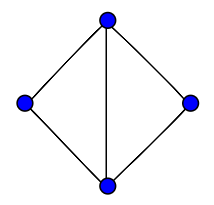

#### Modélisation
On sait que pour un graphe comportant $n$ sommets, on aura besoin, au maximum, de $n$ couleurs (**pour quel type de graphe ?**).

On note $c_1, c_2,...,c_n$ les variables associées à chaque couleur, de sorte que $c_i = 1$ si au moins un sommet utilise la couleur $i$, et $c_i = 0$ sinon.

**Ecrivez la fonction objectif du problème**

On note $x_{ij}$ la variable qui vaut 1 si le sommet $i$ du graphe est colorié avec la couleur $j$.

**Ecrivez la liste des contraintes signifiant que chaque sommet ne doit avoir qu'une et une seule couleur**

**Ecrivez la liste des contraintes signifiant que deux sommets voisins ne peuvent pas avoir la même couleur**

**Ecrivez la liste des contraintes forçant la variable $c_j$ à 1, dès qu'une variable $x_{ij}$ vaut 1**

#### Résolution
Utilisez `PuLP` pour résoudre le programme linéaire que vous venez d'écrire.

💡 Pensez à utiliser des boucles pour créer vos contraintes, et à afficher le modèle créé pour vérifier qu'il correspond bien à ce que vous avez obtenu lors de la modélisation.

Pour les plus curieux... et les plus téméraires, la documentation de `PuLP` donne un exemple complet de résolution d'un sudoku à l'aide d'un programme linéaire : https://coin-or.github.io/pulp/CaseStudies/a_sudoku_problem.html